In this notebook we provide code to test the Good-Toulmin predictor proposed by Orlirsky [2016] and more recently Chakraborty [2019];

In [5]:
import sys
sys.path.append('../utils_folder/')
import matplotlib.pyplot as  plt
from utils_all import *
from utils_gt import *
from utils_bnp import *
from tqdm import *
import scipy as sp
from scipy.special import gammaln as gln
from matplotlib import ticker
def my_formatter_fun(x, p):
    return "%.0f" % (x * (10 ** scale_pow))
scale_pow = -2
color_ls = ['red', 'orange', 'violet', 'purple']
marker_ls = ['o', 'v', '^', 'x']

In [6]:
K = int(10e3)
alpha_ls = [10e-3, 10e-4, 5e-4]
beta_ls = [1,1,1]
N = 2000
N_train = 100
M = N - N_train
B = 10
lo_hi = np.linspace(0,N-1,11, dtype = int)

In [10]:
fig_gt_0 = {}
for a, alpha in enumerate(alpha_ls):
    print('Generating data from a Beta-Bernoulli product model with K = ', K,' total variants; Beta params: (alpha, beta) = ', alpha, beta_ls[a])

    theta = np.random.beta(a = alpha, b = 1, size = K)
    theta = theta[theta>0]
    X = np.random.binomial(n=1, p=np.repeat(theta,N).reshape(theta.shape[0],N).T)
    fig_gt_0[alpha] = {}
    bnp = np.zeros([B, N+1])
    gt = np.zeros([2, B, N+1])
    print('Learning parameters: fold #')
    for b in tqdm_notebook(range(B)):
        
        lo = lo_hi[b]
        X_ = np.roll(X, shift = lo, axis = 0)
        cts = np.concatenate(([0],np.count_nonzero(X_.cumsum(axis = 0), axis = 1)))
        sfs = np.bincount(X_[:N_train].sum(axis = 0))[1:]
# #         print('ok')
        if len(sfs < N_train):
            sfs = np.concatenate((sfs, np.zeros(N_train - len(sfs))))
        opt_p, opt_v = optimize_(train_counts=cts, num_its=3, norm=2, status=False)
        bnp[b] = compute_predicted(M=N-N_train,N=N_train, optimal_params= opt_p, train_counts= cts)

        for a, alt in enumerate([False, True]):
            gt[a,b] = pred_new_gt(N_train=N_train, M=M+1, sfs=sfs, cts=cts, alternative=a)
                    
    bnp_m, bnp_s = bnp.mean(axis = 0), bnp.std(axis = 0)
    fig_gt_0[alpha]['bnp_m'], fig_gt_0[alpha]['bnp_s'] = bnp_m, bnp_s
    fig_gt_0[alpha]['gt_m'], fig_gt_0[alpha]['gt_s'] = gt.mean(axis = 1), gt.std(axis = 1)
    fig_gt_0[alpha]['cts'], fig_gt_0[alpha]['sfs'] = cts, sfs

# np.save('figure_gt_0', fig_gt_0)

Generating data from a Beta-Bernoulli product model with K =  10000  total variants; Beta params: (alpha, beta) =  0.01 1
Learning parameters: fold #


A Jupyter Widget


Generating data from a Beta-Bernoulli product model with K =  10000  total variants; Beta params: (alpha, beta) =  0.001 1
Learning parameters: fold #


A Jupyter Widget


Generating data from a Beta-Bernoulli product model with K =  10000  total variants; Beta params: (alpha, beta) =  0.0005 1
Learning parameters: fold #


A Jupyter Widget

C:\Users\loren\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


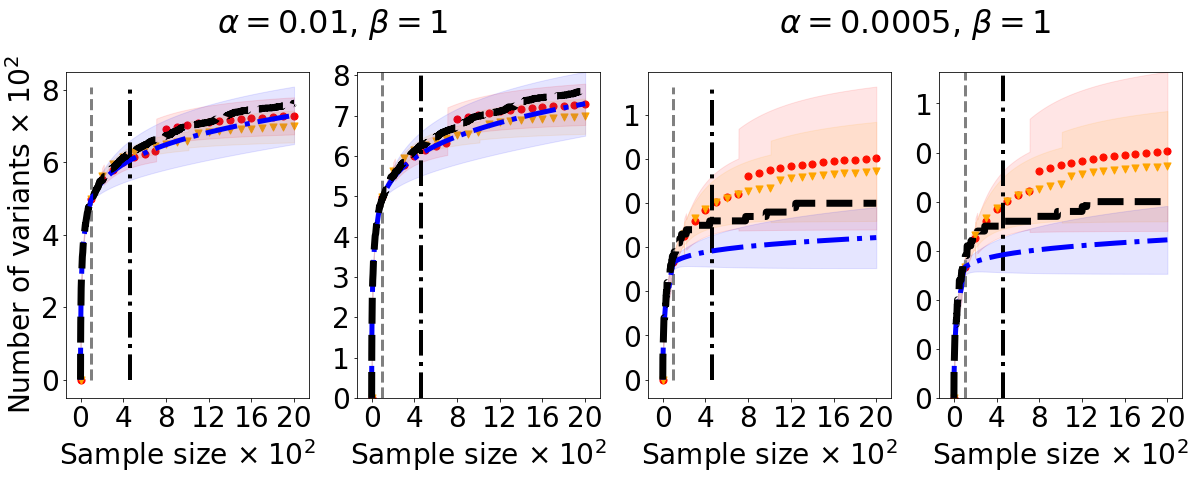

In [23]:
plt.figure(figsize = (20,6))
x = np.linspace(0,200,5,dtype = int)
c_ = 0
data = fig_gt_0 # or alternatively, save and load
for a, alpha in enumerate([alpha_ls[0], alpha_ls[2]]):
    height = 0
    cts = data[alpha]['cts']
    N = len(cts)-1
    
    bnp_m, bnp_s = data[alpha]['bnp_m'], data[alpha]['bnp_s']
    height = max(height, bnp_m[-1]+bnp_s[-1])
    for zz in range(1,3):
        c_+=1
        ax = plt.subplot(1, 4, c_)
        
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 
        ax.xaxis.get_offset_text().set_fontsize(28)
        ax.yaxis.get_offset_text().set_fontsize(28)
        ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(my_formatter_fun))
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(my_formatter_fun))
        ax.set_xlabel('Sample size ' + r'$\times \;10^{{{0:d}}}$'.format(-scale_pow), fontsize = 28)
        if a ==0 :
            if zz == 1:
                ax.set_ylabel('Number of variants ' + r'$\times \;10^{{{0:d}}}$'.format(-scale_pow), fontsize = 28)
        if a == 0:
            plt.legend(fontsize = 22, loc = 'lower right')
        plt.xticks(np.linspace(0,N, 6), fontsize = 28)
        plt.yticks(fontsize = 28)
        
        for a, alt in enumerate([False, True]):

    
            gt_m, gt_s = data[alpha]['gt_m'][a], data[alpha]['gt_s'][a]
            plt.scatter(range(N+1)[::100], gt_m[::100], color = color_ls[a], s = 50, marker = marker_ls[alt])
            plt.fill_between(range(N+1), gt_m- gt_s, gt_m + gt_s, alpha=0.1, color = color_ls[alt])
            height = max(height, gt_m[-1]+gt_s[-1])       

#         plt.xlabel('Sample size', fontsize = 28)
        plt.plot(range(N+1), bnp_m, color = 'blue', linewidth = 5, linestyle = '-.', label = 'BNP')
        plt.fill_between(range(N+1), bnp_m - bnp_s, bnp_m + bnp_s, alpha=0.1, color = 'blue')
        plt.vlines(x = N_train, ymin=0, ymax=max(cts[-1], height), color = 'gray', linestyle = '--', linewidth  = 3) #max(bnp_m[:,-1]+bnp_s[:,-1])
        plt.plot(range(N+1), cts, color = 'k', linewidth = 7, linestyle = '--', label = 'True')
        
        plt.vlines(x = N_train * np.log(N_train), ymin = 0, ymax=max(cts[-1], height), color = 'k', linestyle = '-.', linewidth  = 4, label = r'$N\log N$')
        
        if a == 0:
            plt.legend(fontsize = 25, loc = 'lower right')
        if zz == 1:
            plt.title(r'$\alpha = $'+str(alpha)+r', $\beta = 1$', x = 1.1,y =1.1, fontsize = 32)
        
    plt.ylim([0,height])
# # plt.tight_layout()
# plt.savefig('jack_double.pdf', dpi = 1000 , bbox_inches = 'tight')
plt.show()